In [1]:
import csv
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle

def loadImage(line):
    xs = []
    ys = []
    
    correction = 0.22
    
    for view in range(3):
        origPath = line[view]
        filename = origPath.split('/')[-1]
        newPath = "data/IMG/" + filename
        
        x = cv2.imread(newPath)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        steer = float(line[3])
                       
        if view == 1: # Left view
            steer += correction
        if view == 2: # Right view
            steer -= correction
        
        xs.append(np.array(x))
        ys.append(steer)
        
    
    return xs,ys

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                xs, ys = loadImage(batch_sample)
                for i in range(len(xs)):
                    x = xs[i]
                    y = ys[i]
                    images.append(x)
                    angles.append(y)
                    images.append(cv2.flip(x, 1))
                    angles.append(-1*y)

#             print("#lines {}, #batch_lines {}, ylen {}, total {}".format(len(samples), len(batch_samples), len(ys), len(angles)))
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)


In [21]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Lambda, Convolution2D,MaxPooling2D, Dropout, Cropping2D
from keras.optimizers import Adam
import tensorflow as tf

top_crop, bottom_crop = 50, 20
ch, row, col = 3, 160, 320  # Trimmed image format

model = Sequential()
model.add(Lambda(lambda x:x/127.5 - 1.0, input_shape=(row,col,ch)))
model.add(Cropping2D(cropping=((top_crop,bottom_crop), (0,0)), dim_ordering='tf'))
# model.add(Lambda(lambda image: tf.image.resize_images(image, (64, 64))))
    
def AlexNet(model):
    model.add(Convolution2D(6,5,5,activation="relu"))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6,5,5,activation="relu"))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dropout(0.2))
    model.add(Dense(84))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def NvidiaNet(model):
    model.add(Convolution2D(24,5,5, subsample=(2,2),activation="relu"))
    model.add(Convolution2D(36,5,5, subsample=(2,2),activation="relu"))
    model.add(Convolution2D(48,5,5, subsample=(2,2),activation="relu"))
    model.add(Convolution2D(64,3,3, activation="relu"))
    model.add(Convolution2D(64,3,3, activation="relu"))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

# model = AlexNet(model)
model = NvidiaNet(model)

In [22]:

# load training file list
lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
from sklearn.model_selection import train_test_split
train_lines, validation_lines = train_test_split(lines, test_size=0.2)

print('Training size: ', len(train_lines))
print('Validation size: ', len(validation_lines))

batchSize = 128
# compile and train the model using the generator function
train_generator = generator(train_lines, batch_size=batchSize)
validation_generator = generator(validation_lines, batch_size=batchSize)


Training size:  5288
Validation size:  1322


In [25]:

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=adam)

# history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=10, batch_size=256, verbose=1)

history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_lines), \
                                     validation_data=validation_generator, \
                                     nb_val_samples=len(validation_lines), \
                                     nb_epoch=25, \
                                     verbose = 1)

# model.save('model_center_andLeftRight_cropped_TwoTracks_AlexNet.h5')
model.save('model_center_andLeftRight_cropped_TwoTracks_NvidiaNet.h5')


Epoch 1/25
4608/5288 [=========================>....] - ETA: 1s - loss: 0.1031

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


5376/5288 [==============================] - 15s - loss: 0.0998 - val_loss: 0.1022
Epoch 2/25
5616/5288 [===============================] - 15s - loss: 0.0805 - val_loss: 0.1045
Epoch 3/25
5376/5288 [==============================] - 15s - loss: 0.0936 - val_loss: 0.0761
Epoch 4/25
5376/5288 [==============================] - 15s - loss: 0.0933 - val_loss: 0.0910
Epoch 5/25
5376/5288 [==============================] - 15s - loss: 0.0965 - val_loss: 0.0997
Epoch 6/25
5376/5288 [==============================] - 15s - loss: 0.0902 - val_loss: 0.0971
Epoch 7/25
5376/5288 [==============================] - 15s - loss: 0.0827 - val_loss: 0.0965
Epoch 8/25
5616/5288 [===============================] - 15s - loss: 0.0787 - val_loss: 0.0735
Epoch 9/25
5376/5288 [==============================] - 15s - loss: 0.0869 - val_loss: 0.0856
Epoch 10/25
5376/5288 [==============================] - 15s - loss: 0.0874 - val_loss: 0.0954
Epoch 11/25
5376/5288 [==============================] - 14s - loss:

dict_keys(['loss', 'val_loss'])


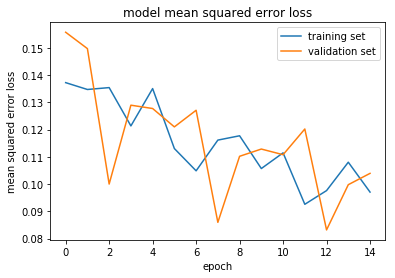

In [24]:
from keras.models import Model
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()